# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import textwrap
import random
import torch
import time
import datetime
import logging
from torch import nn
from torch.nn import BCEWithLogitsLoss
from transformers import BertPreTrainedModel, BertModel
from transformers import BertTokenizer
from transformers import AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Defining our MultiLabel Model

## BertForMultiLabelSequenceClassification

In [3]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    
    def __init__(self, config):
        # call the parent function of the parent class (BertPreTrainedModel)
        super().__init__(config)
        
        # store number of labels
        self.num_labels = config.num_labels
        
        # create BERT model
        self.bert = BertModel(config)
        
        # setup dropout object
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        # create [768 X 6] weight matrix to use as our classifier
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        
        # initialize model weights
        self.init_weights()
        
    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                position_ids=None,
                head_mask=None,
                inputs_embeds=None,
                labels=None,
                output_attentions=None,
                output_hidden_states=None):
        
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        
        sequence_output = outputs[0]
        pooled_output = outputs[1]
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            # Binary Cross Entropy Loss
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return (loss, logits) + outputs[2:]
        else:
            return (logits,) + outputs[2:]

# Retrieve and Inspect Dataset

## Parse and Inspect

In [6]:
train = pd.read_csv('train.csv')

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
train.shape

(159571, 8)

There are roughly 160k training examples.

## Class Distribution

In [10]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [11]:
# labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# select just the labels
has_labels = train[label_cols].any(axis=1)

# add new column indicating which samples have no toxic labels
train['none'] = 1 - has_labels

# add 'none' column to our list of label names
label_cols.append('none')

Total number of samples with each label

In [12]:
label_counts = train[label_cols].sum(axis=0)
label_counts

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64

In [13]:
print('{:.1%} of comments are safe.'.format(label_counts['none'] / len(train)))

89.8% of comments are safe.


How many samples are there for each type?

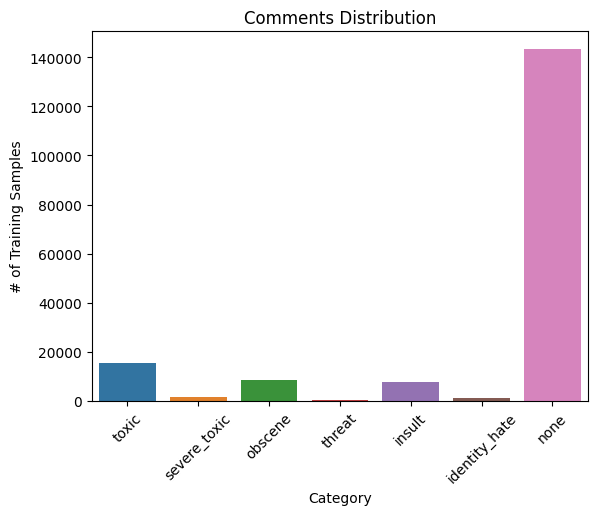

In [14]:
# Plot number of tokens of each length
sns.barplot(x=label_cols, y=label_counts)
plt.title('Comments Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')
plt.xticks(rotation=45)
plt.show()

# Tokenization and Truncation

## Load BertTokenizer

In [15]:
print('Loading BERT TOkenizer...')
tokenizer = BertTokenizer.from_pretrained(
                                'bert-base-uncased',
                                do_lower_case=True)

Loading BERT TOkenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Comment Length Distribution

In [16]:
logging.getLogger('transformers.tokenization_utils_base').setLevel(logging.ERROR)

# record length of each sentece
lengths = []

print('Tokenizing comments...')

# for every sentence...
for index, row in train.iterrows():
    # report progress
    if ((len(lengths) % 20000) == 0):
        print('Tokenized {:,} comments.'.format(len(lengths)))
        
    encoded_sent = tokenizer.encode(
                        row['comment_text'],      # sentence to encode
                        add_special_tokens=True   # ad [CLS] and [SEP] token
                    )
    # record non-truncated length
    lengths.append(len(encoded_sent))
    
print('DONE.')

Tokenizing comments...
Tokenized 0 comments.
Tokenized 20,000 comments.
Tokenized 40,000 comments.
Tokenized 60,000 comments.
Tokenized 80,000 comments.
Tokenized 100,000 comments.
Tokenized 120,000 comments.
Tokenized 140,000 comments.
DONE.


In [17]:
print('Minimum length: {:,} tokens'.format(min(lengths)))
print('Maximum length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

Minimum length: 4 tokens
Maximum length: 4,950 tokens
Median length: 52 tokens


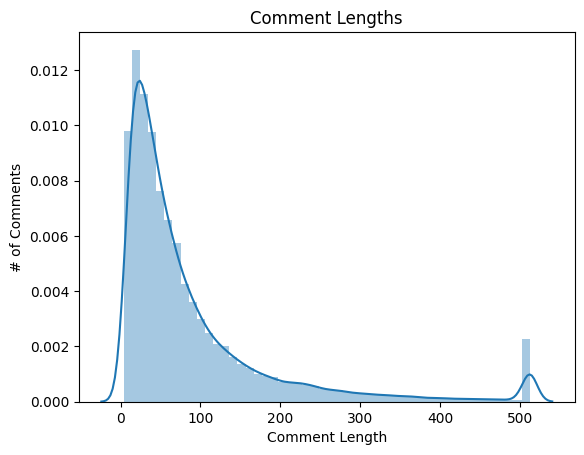

In [18]:
# truncate any comment greater than 512
trunc_lengths = [min(l, 512) for l in lengths]

# plot the distribution of comment lengths
sns.distplot(trunc_lengths, kde=True, rug=False)

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

plt.show()

In [19]:
# set the sequence length
max_len = 128

## Tokenize Dataset

In [21]:
input_ids = []
attn_masks= []
labels = []

t0 = time.time()

print('Encoding {:,} Training Examples...'.format(len(train)))

# for every training example
for index, row in train.iterrows():
    if ((len(input_ids) % 15000) == 0):
        print('Encoded {:,} comments.'.format(len(input_ids)))
        
    # convert sentence pairs to input IDs, with attention masks
    encoded_dict = tokenizer.encode_plus(
                                row['comment_text'],
                                max_length = max_len,
                                pad_to_max_length = True,
                                truncation=True,
                                return_tensors='pt')
    
    # add example to list
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])

print('DONE. {:,} examples.'.format(len(input_ids)))

Encoding 159,571 Training Examples...
Encoded 0 comments.
Encoded 15,000 comments.
Encoded 30,000 comments.
Encoded 45,000 comments.
Encoded 60,000 comments.
Encoded 75,000 comments.
Encoded 90,000 comments.
Encoded 105,000 comments.
Encoded 120,000 comments.
Encoded 135,000 comments.
Encoded 150,000 comments.
DONE. 159,571 examples.


In [22]:
# convert each python list of Tensors into 2d Tensor matrix
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# select label columns
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
labels = labels.to_numpy().astype(float)
labels = torch.tensor(labels)

print('Data Structure shapee:\n')
print('input ids: {:}'.format(str(input_ids.shape)))
print('attention masks: {:}'.format(str(attn_masks.shape)))
print('labels : {:}'.format(labels.shape))

print('encoding took {:.2f} seconds'.format(time.time() - t0))

Data Structure shapee:

input ids: torch.Size([159571, 128])
attention masks: torch.Size([159571, 128])
labels : torch.Size([159571, 6])
encoding took 475.98 seconds


## Train Validation Splitting

In [23]:
# combine training inputs into TensorDataset
dataset = TensorDataset(input_ids, attn_masks, labels)

# create train-validation split
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

# divide dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Use GPU for Training

In [24]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use GPU: ', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead...')
    device = torch.device('cpu')

There are 2 GPU(s) available.
We will use GPU:  Tesla T4


## Initialize model with Pre-trained Weights

In [25]:
model = BertForMultiLabelSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Model loaded.')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.


## Batch Size and DataLoaders

In [26]:
# batch size 
batch_size = 32

# create dataloader fro training set
train_dataloader = DataLoader(
                        train_dataset,
                        sampler = RandomSampler(train_dataset),
                        batch_size = batch_size
                    )

# create dataloader fro validation set
val_dataloader = DataLoader(
                        val_dataset,
                        sampler = SequentialSampler(val_dataset),
                        batch_size = batch_size
                    )

## Optimizer

In [27]:
# creating an optimizer for performing actual updates to model weights
optimizer = AdamW(model.parameters(),
                 lr = 2e-5,
                 eps = 1e-8
                )

## Epochs and Learning Rate Scheduler

In [28]:
epochs = 3

# total steps is # of batches * # of epochs
total_steps = len(train_dataloader) * epochs

# create learning rate scheuler
scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=0,
                    num_training_steps=total_steps
                )

## Helper Funtions

In [29]:
def format_time(elapsed):
    # round to nearest second
    elapsed_rounded = int(round(elapsed))
    
    # format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
def good_update_interval(total_iters, num_desired_updates):
    
    exact_interval = total_iters / num_desired_updates
    
    # get order of magnitude of the total
    order_of_mag = len(str(total_iters)) - 1
    
    # round to an order of mangnitude smaller
    rounded_mag = order_of_mag - 1
    
    # update interval
    update_interval = int(round(exact_interval, -rounded_mag))
    
    if update_interval == 0:
        update_interval = 1
        
    return update_interval

## Training Loop

In [31]:

# set the seed value
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# for storing training and validation loss, validation accuracy and timings
training_stats = []

# measure total training time for whole run
total_t0 = time.time()

# for each epoch...
for epoch in range(0, epochs):

  # ==================================================
  #                       Training
  # ==================================================

  print("")
  print('------------ Epoch {:} / {:} ------------'.format(epoch+1, epochs))
  print('training...')

  # for measuring how long each training epoch takes
  t0 = time.time()

  # reset total loss for this epoch
  total_train_loss = 0

  # put the model into training mode
  model.train()
    
  # pick interval on which print progress updates
  update_interval = good_update_interval(
                          total_iters = len(train_dataloader),
                          num_desired_updates = 10
                      )

  # for each batch of training data...
  for step, batch in enumerate(train_dataloader):

    # progress update
    if (step % update_interval) == 0 and not step == 0:
      # calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)

      # report progres
      print(' Batch {:>5,} of {:>5,}. Elapsed : {:}.'.format(step, len(train_dataloader), elapsed))

    # unpack training batch from dataloader
    batch_input_ids = batch[0].to(device)
    batch_input_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    # clear any previously calculated gradients before performing backward pass
    model.zero_grad()

    # perform forward pass (evaluate model on this training batch)
    loss, logits = model(
                batch_input_ids,
                token_type_ids = None,
                attention_mask=batch_input_mask,
                labels = batch_labels,
              )


    # accumulate the training loss over all of batches
    total_train_loss += loss.item()

    # perform backward pass to calculate gradients
    loss.backward()

    # clip the norm of gradients to 1.0
    # that will help in preventing exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters and take step using computed gradient
    optimizer.step()

    # update the learning rate
    scheduler.step()

  # calculate average loss over all of batches
  avg_train_loss = total_train_loss / len(train_dataloader)

  # measure how long this epoch took
  training_time = format_time(time.time() - t0)

  print('')
  print('Average training loss : {0:.2f}'.format(avg_train_loss))
  print(' Training epoch took : {:}'.format(training_time))

  # ==================================================
  #                       Validation
  # ==================================================

  print("")
  print(' Running Validation...')

  t0 = time.time()

  # put the model in evaluation
  model.eval()

  # traking variables
  total_eval_loss = 0

  predictions, true_labels = [], []

  # evaluate data for one epoch
  for batch in val_dataloader:

    # unpack training batch from dataloader
    batch_input_ids = batch[0].to(device)
    batch_input_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    # no need for constructing graph during forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
      # forward pass, calculate logit predictions
      (loss, logits) = model(
                batch_input_ids,
                token_type_ids = None,
                attention_mask=batch_input_mask,
                labels = batch_labels,
              )

    # accumulate the validation loss
    total_eval_loss += loss.item()

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    
    # store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  # measure validation accuracy...
  
  # combine results across all batches
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
 
  # report the validation accuracy for this validation run
  val_accuracy = roc_auc_score(flat_true_labels, flat_predictions, average = 'macro')
  print("Accuracy : {0:.2f}".format(val_accuracy))
    
  # calculate avg loss over all of batches
  avg_val_loss = total_eval_loss / len(val_dataloader)

  # measure how long validation run took
  val_time = format_time(time.time() - t0)

  print('Validation loss : {0:.2f}'.format(avg_val_loss))
  print(' Validation took : {:}'.format(val_time))

  # record all statistics from this epoch
  training_stats.append(
      {
          'epoch' : epoch + 1,
          'train loss' : avg_train_loss,
          'valid loss' : avg_val_loss,
          'valid accuracy' : val_accuracy,
          'training time' : training_time,
          'validation time' : val_time
      }
  )

print('')
print('Training completed...')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


------------ Epoch 1 / 3 ------------
training...
 Batch   400 of 4,488. Elapsed : 0:04:23.
 Batch   800 of 4,488. Elapsed : 0:08:52.
 Batch 1,200 of 4,488. Elapsed : 0:13:22.
 Batch 1,600 of 4,488. Elapsed : 0:17:51.
 Batch 2,000 of 4,488. Elapsed : 0:22:20.
 Batch 2,400 of 4,488. Elapsed : 0:26:50.
 Batch 2,800 of 4,488. Elapsed : 0:31:19.
 Batch 3,200 of 4,488. Elapsed : 0:35:49.
 Batch 3,600 of 4,488. Elapsed : 0:40:19.
 Batch 4,000 of 4,488. Elapsed : 0:44:48.
 Batch 4,400 of 4,488. Elapsed : 0:49:17.

Average training loss : 0.05
 Training epoch took : 0:50:16

 Running Validation...
Accuracy : 0.99
Validation loss : 0.04
 Validation took : 0:01:57

------------ Epoch 2 / 3 ------------
training...
 Batch   400 of 4,488. Elapsed : 0:04:29.
 Batch   800 of 4,488. Elapsed : 0:08:58.
 Batch 1,200 of 4,488. Elapsed : 0:13:27.
 Batch 1,600 of 4,488. Elapsed : 0:17:57.
 Batch 2,000 of 4,488. Elapsed : 0:22:26.
 Batch 2,400 of 4,488. Elapsed : 0:26:56.
 Batch 2,800 of 4,488. Elapsed : 

In [32]:
# display floats with two decimal places
pd.set_option('display.precision', 2)

# create dataframe from our training statistics
df_stats = pd.DataFrame(data = training_stats)

# use epoch as row index
df_stats = df_stats.set_index('epoch')

# display the table
df_stats

,train loss,valid loss,valid accuracy,training time,validation time
epoch,,,,,
1,0.05,0.04,0.99,0:50:16,0:01:57
2,0.03,0.04,0.99,0:50:21,0:01:57
3,0.02,0.04,0.99,0:50:23,0:01:58


The model showed a significant reduction in training loss while maintaining a stable validation loss and high validation accuracy, indicating strong performance and potential generalization capabilities.